In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/libras/test/N/173.png
/kaggle/input/libras/test/N/491.png
/kaggle/input/libras/test/N/379.png
/kaggle/input/libras/test/N/248.png
/kaggle/input/libras/test/N/94.png
/kaggle/input/libras/test/N/480.png
/kaggle/input/libras/test/N/236.png
/kaggle/input/libras/test/N/340.png
/kaggle/input/libras/test/N/48.png
/kaggle/input/libras/test/N/513.png
/kaggle/input/libras/test/N/350.png
/kaggle/input/libras/test/N/314.png
/kaggle/input/libras/test/N/227.png
/kaggle/input/libras/test/N/238.png
/kaggle/input/libras/test/N/61.png
/kaggle/input/libras/test/N/377.png
/kaggle/input/libras/test/N/222.png
/kaggle/input/libras/test/N/330.png
/kaggle/input/libras/test/N/511.png
/kaggle/input/libras/test/N/278.png
/kaggle/input/libras/test/N/303.png
/kaggle/input/libras/test/N/37.png
/kaggle/input/libras/test/N/231.png
/kaggle/input/libras/test/N/348.png
/kaggle/input/libras/test/N/449.png
/kaggle/input/libras/test/N/353.png
/kaggle/input/libras/test/N/148.png
/kaggle/input/libras/test/N/403.

In [2]:
# Imports das bibliotecas necessárias
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from IPython.display import clear_output
%matplotlib inline

In [3]:
# TensorFlow e Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

2025-05-14 19:07:32.694631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747249652.891843      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747249652.947624      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Configurações gerais
SEED = 42
IMG_SIZE = (128, 128)  # Tamanho das imagens
BATCH_SIZE = 32
EPOCHS = 20

In [5]:
# Verificar se GPU está disponível
print("GPU disponível: ", tf.config.list_physical_devices('GPU'))

GPU disponível:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# 1. Carregamento e preparação dos dados

# Especificar caminhos para os diretórios de dados
DATASET_PATH = "/kaggle/input/libras"
TRAIN_DIR = os.path.join(DATASET_PATH, "train")
VAL_DIR = os.path.join(DATASET_PATH, "test")  # vamos usar o test como validação

In [7]:
# Verificar se os diretórios existem
print(f"Verificando caminhos dos dados:")
print(f"Dataset path existe: {os.path.exists(DATASET_PATH)}")

Verificando caminhos dos dados:
Dataset path existe: True


In [8]:
# 2. Preparação dos geradores de dados
# ImageDataGenerator é usado para aumentar artificialmente o conjunto de dados
# e normalizar as imagens

# Generator para o conjunto de treinamento (com aumentação de dados)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,           # rotação aleatória
    width_shift_range=0.2,       # Deslocamento horizontal
    height_shift_range=0.2,      # Deslocamento vertical
    shear_range=0.2,             # Cisalhamento
    zoom_range=0.2,              # zoom
    horizontal_flip=True,        # Flip horizontal
    fill_mode='nearest',         # Método de preenchimento
    validation_split=0.2         # 20% para validação
)

In [9]:
# Generator para o conjunto de validação e teste (apenas normalização)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [10]:
# Criação dos geradores de fluxo de dados
try:
    # Generator para parte de treinamento
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=SEED,
        subset='training'
    )

    # Generator para parte de validação
    validation_generator = val_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        seed=SEED,
        subset='validation'
    )

    # Generator para conjunto de teste
    test_generator = test_datagen.flow_from_directory(
        VAL_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        seed=SEED
    )
    
    # Obter informações sobre os conjuntos de dados
    num_train_samples = train_generator.samples
    num_validation_samples = validation_generator.samples
    num_test_samples = test_generator.samples
    
    # Lista de classes (letras do alfabeto em Libras)
    classes = list(train_generator.class_indices.keys())
    num_classes = len(classes)
    
    print(f"Classes detectadas: {classes}")
    print(f"Número de classes: {num_classes}")
    print(f"Amostras de treino: {num_train_samples}")
    print(f"Amostras de validação: {num_validation_samples}")
    print(f"Amostras de teste: {num_test_samples}")

except Exception as e:
    print(f"Erro ao carregar os dados: {e}")

Found 27774 images belonging to 21 classes.
Found 6940 images belonging to 21 classes.
Found 11548 images belonging to 21 classes.
Classes detectadas: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']
Número de classes: 21
Amostras de treino: 27774
Amostras de validação: 6940
Amostras de teste: 11548


In [11]:
# Visualizar algumas imagens de exemplo do conjunto de treinamento
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(15, 15))
    for n in range(min(25, len(image_batch))):
        ax = plt.subplot(5, 5, n + 1)
        # Normalizar as imagens para exibição
        img = (image_batch[n] + 1) / 2
        plt.imshow(img)
        if label_batch is not None:
            plt.title(classes[np.argmax(label_batch[n])])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

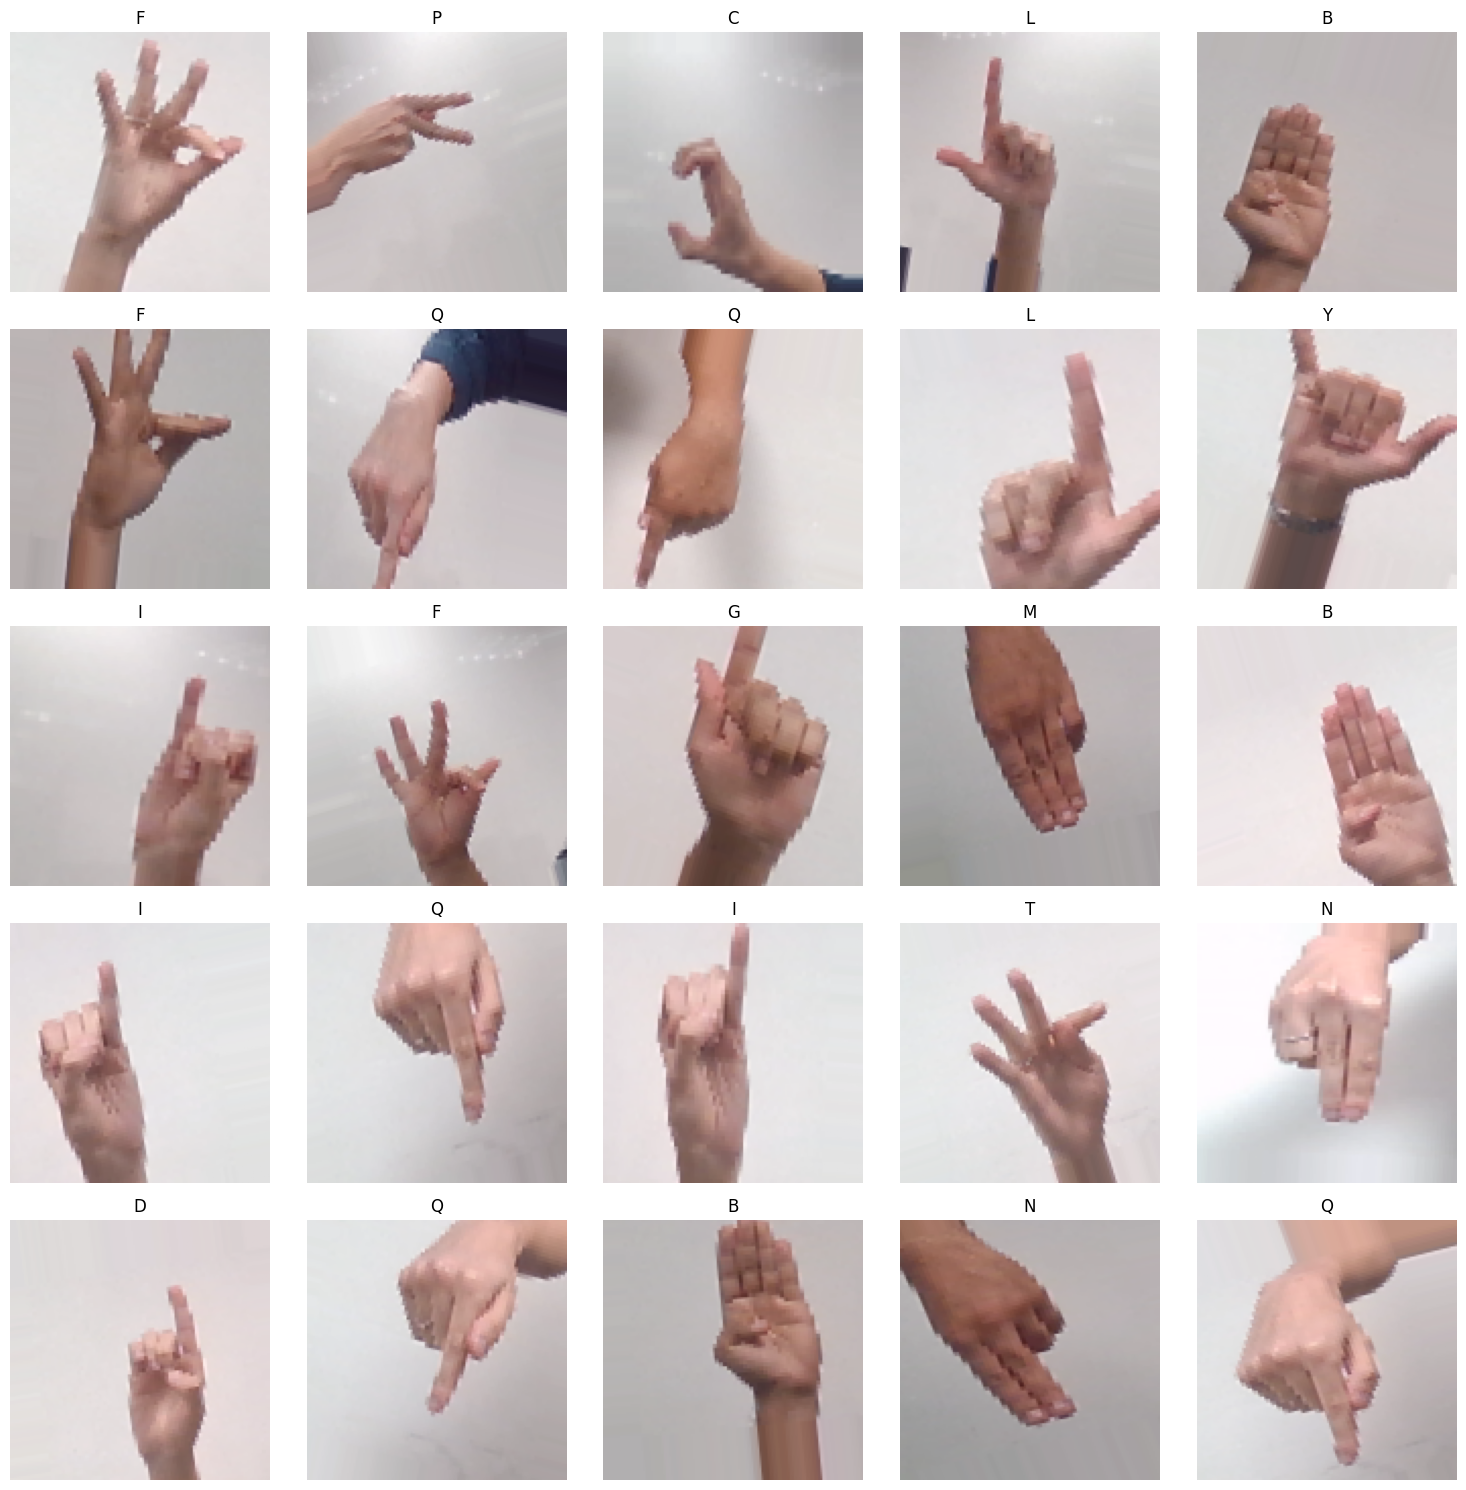

Exemplos de imagens do conjunto de treinamento


In [12]:
# Tentar obter e mostrar um batch de imagens
try:
    image_batch, label_batch = next(iter(train_generator))
    show_batch(image_batch, label_batch)
    print("Exemplos de imagens do conjunto de treinamento")
except Exception as e:
    print(f"Erro ao visualizar imagens: {e}")


In [13]:
def create_model():
    base_model = InceptionResNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    )
    
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model 

In [14]:
# Criar o modelo
try:
    model = create_model()
    model.summary()
except Exception as e:
    print(f"Erro ao criar o modelo: {e}")

I0000 00:00:1747249674.765644      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_resnet_v2 (Functional)     │ (None, 2, 2, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 21)                  │           5,397 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,260,405 (210.80 MB)

 Trainable params: 923,669 (3.52 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [15]:
# 4. Treinamento do modelo
# Callbacks para salvar o melhor modelo e parar antes se não houver melhoria
callbacks = [
    ModelCheckpoint(
        filepath='sequential_2.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        verbose=1,
        restore_best_weights=True
    )
]

In [16]:
# 4. Treinamento do modelo
# callbacks para salvar o melhor modelo e parar antes se não houver melhoria
callbacks = [
    ModelCheckpoint(
        filepath='sequential_2.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        verbose=1,
        restore_best_weights=True
    )
]

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1747249706.801563     120 service.cc:148] XLA service 0x786370002dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747249706.802202     120 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747249711.425883     120 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/867 ━━━━━━━━━━━━━━━━━━━━ 44s 51ms/step - accuracy: 0.0625 - loss: 7.0378   

I0000 00:00:1747249717.910549     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.3261 - loss: 2.4423
Epoch 1: val_accuracy improved from -inf to 0.73018, saving model to sequential_2.keras
867/867 ━━━━━━━━━━━━━━━━━━━━ 270s 270ms/step - accuracy: 0.3262 - loss: 2.4414 - val_accuracy: 0.7302 - val_loss: 0.8710
Epoch 2/20
  1/867 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.6562 - loss: 1.0882

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.73018 to 0.73134, saving model to sequential_2.keras
867/867 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.6562 - loss: 1.0882 - val_accuracy: 0.7313 - val_loss: 0.8689
Epoch 3/20
867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6835 - loss: 0.9739
Epoch 3: val_accuracy improved from 0.73134 to 0.79442, saving model to sequential_2.keras
867/867 ━━━━━━━━━━━━━━━━━━━━ 146s 169ms/step - accuracy: 0.6835 - loss: 0.9738 - val_accuracy: 0.7944 - val_loss: 0.6364
Epoch 4/20
  1/867 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.7812 - loss: 0.6621
Epoch 4: val_accuracy did not improve from 0.79442
867/867 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7812 - loss: 0.6621 - val_accuracy: 0.7928 - val_loss: 0.6363
Epoch 5/20
867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7703 - loss: 0.6860
Epoch 5: val_accuracy improved from 0.79442 to 0.83030, saving model to sequential_2.keras
867/867 ━━━━━━━━━━━━━━━━━━━━ 144s 167ms/step - accura

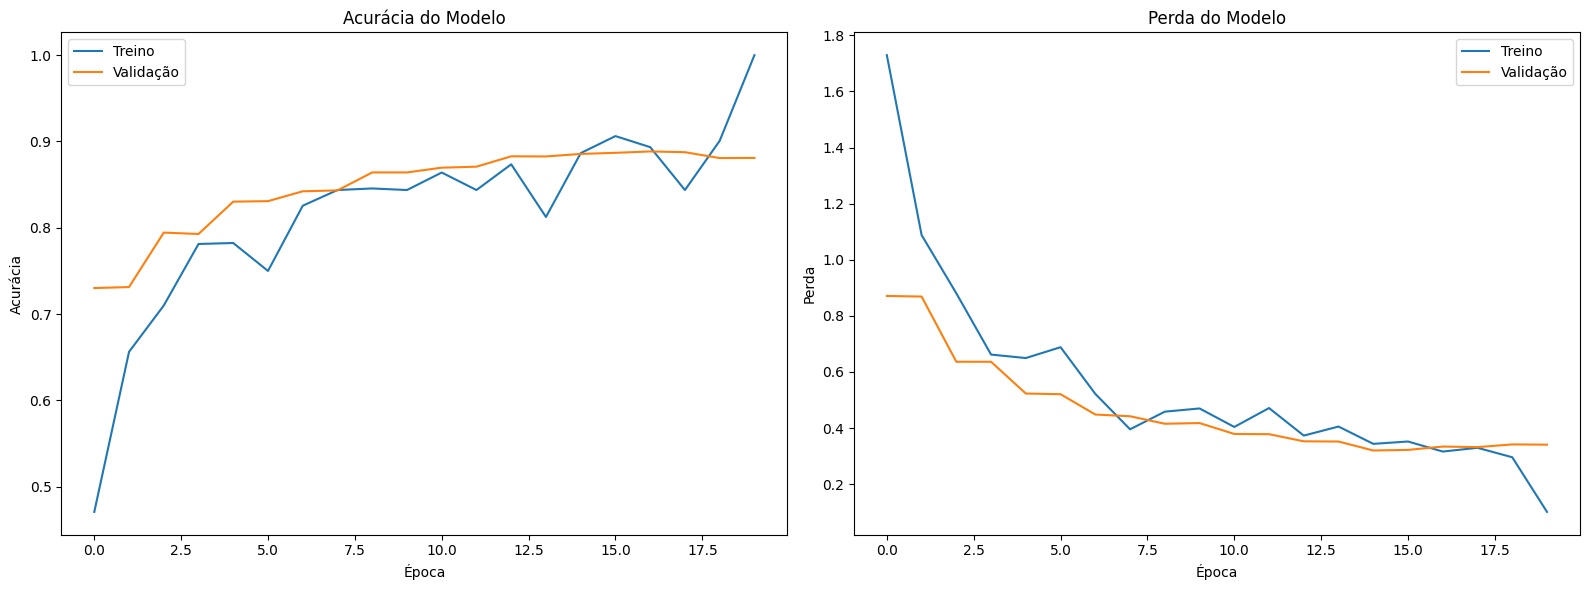

361/361 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step


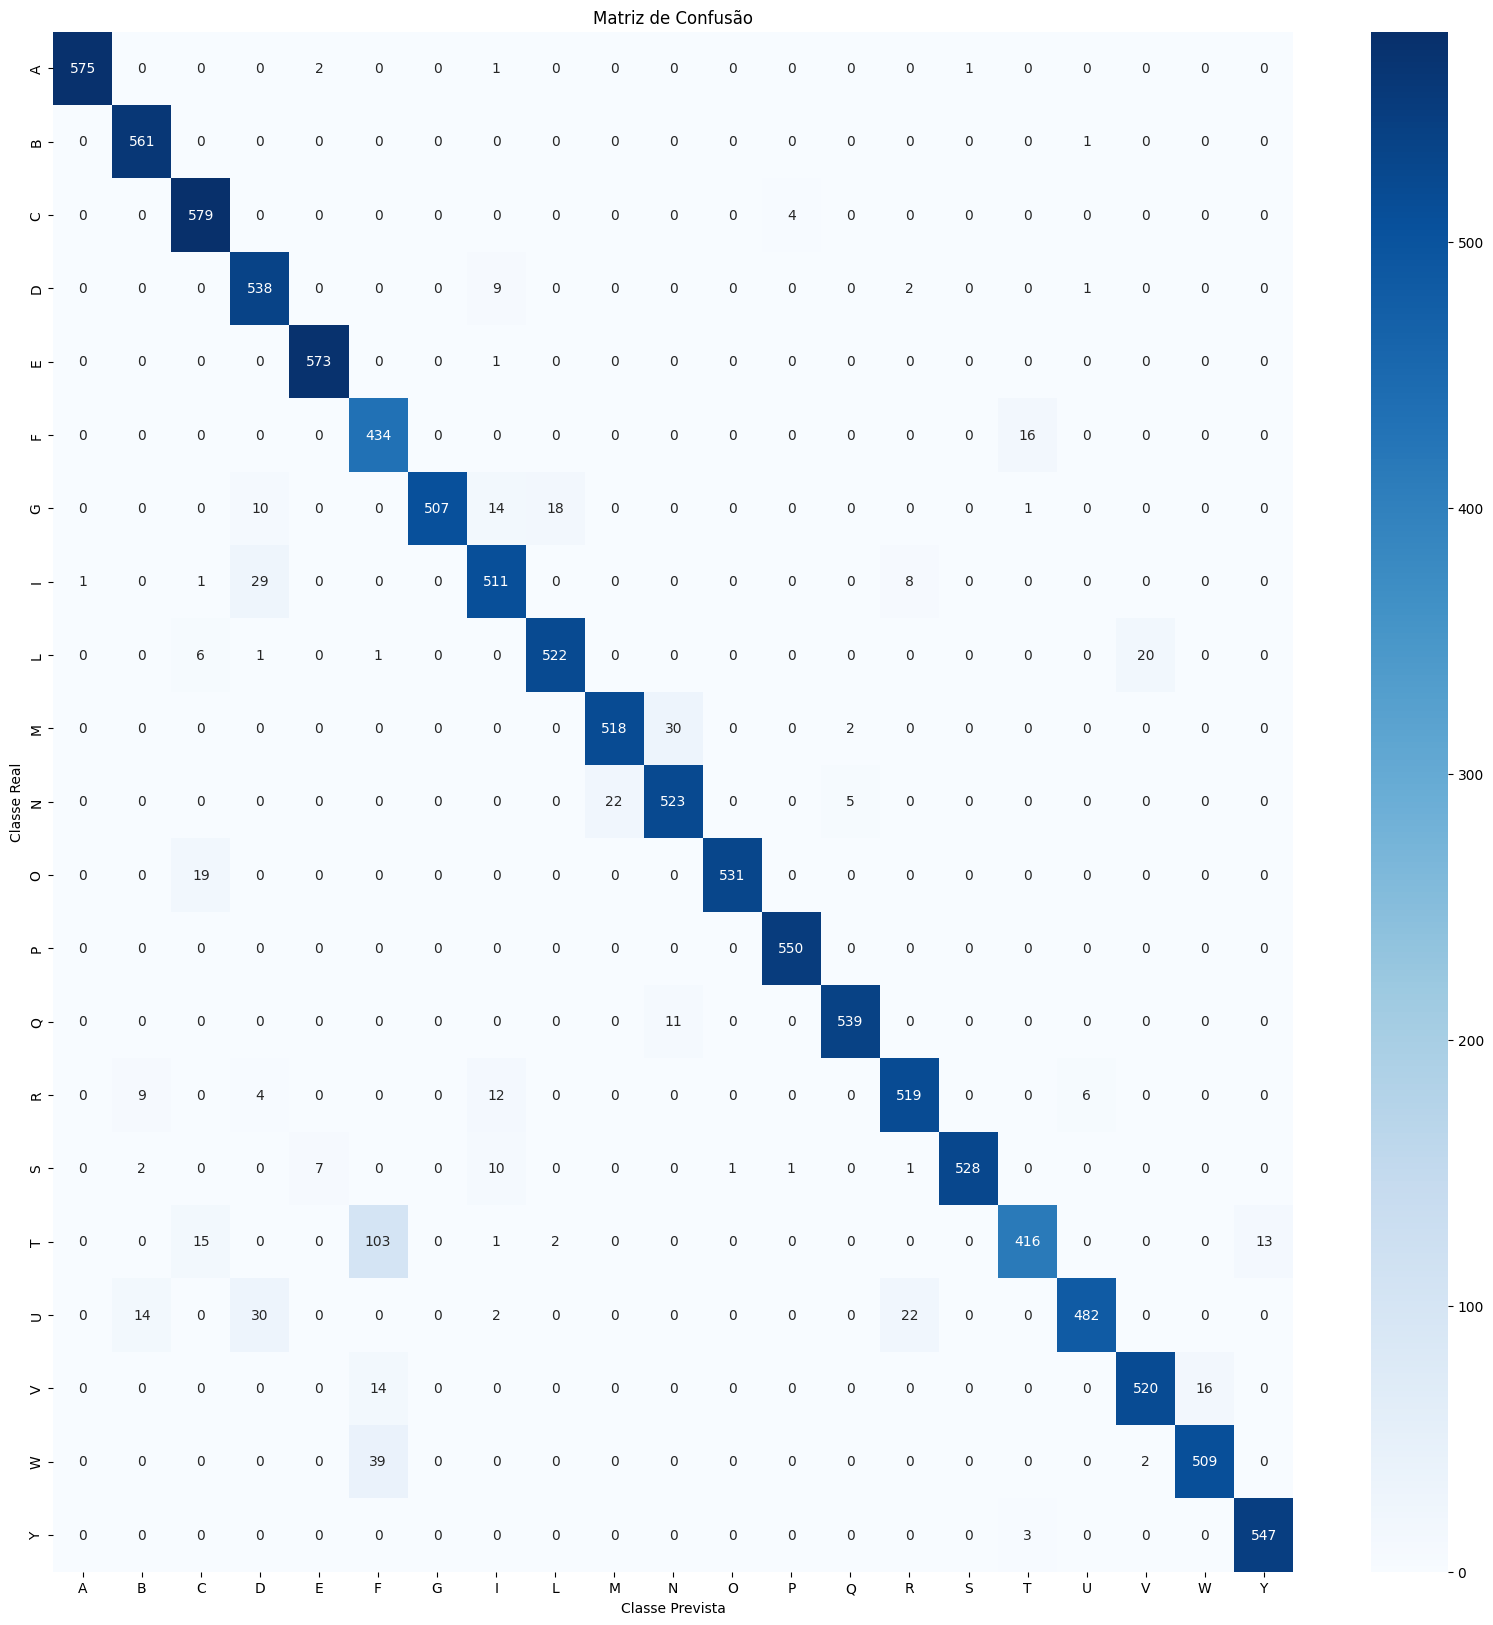

Relatório de Classificação:
              precision    recall  f1-score   support

           A       1.00      0.99      1.00       579
           B       0.96      1.00      0.98       562
           C       0.93      0.99      0.96       583
           D       0.88      0.98      0.93       550
           E       0.98      1.00      0.99       574
           F       0.73      0.96      0.83       450
           G       1.00      0.92      0.96       550
           I       0.91      0.93      0.92       550
           L       0.96      0.95      0.96       550
           M       0.96      0.94      0.95       550
           N       0.93      0.95      0.94       550
           O       1.00      0.97      0.98       550
           P       0.99      1.00      1.00       550
           Q       0.99      0.98      0.98       550
           R       0.94      0.94      0.94       550
           S       1.00      0.96      0.98       550
           T       0.95      0.76      0.84       550

In [17]:
# Treinar o modelo
try:
    history = model.fit(
        train_generator,
        steps_per_epoch=num_train_samples // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=num_validation_samples // BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )
    
    print("Treinamento concluído!")
    
    # 5. Avaliação do modelo
    # Carregar o melhor modelo salvo
    best_model = load_model('sequential_2.keras')
    
    # Avaliar no conjunto de teste
    test_loss, test_accuracy = best_model.evaluate(test_generator)
    print(f"Acurácia no conjunto de teste: {test_accuracy:.4f}")
    print(f"Loss no conjunto de teste: {test_loss:.4f}")
    
    # Visualizar métricas do treinamento
    plt.figure(figsize=(16, 6))
    
    # Plot da acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Treino')
    plt.plot(history.history['val_accuracy'], label='Validação')
    plt.title('Acurácia do Modelo')
    plt.ylabel('Acurácia')
    plt.xlabel('Época')
    plt.legend()
    
    # Plot da perda
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Treino')
    plt.plot(history.history['val_loss'], label='Validação')
    plt.title('Perda do Modelo')
    plt.ylabel('Perda')
    plt.xlabel('Época')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Gerar matriz de confusão
    Y_pred = best_model.predict(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    
    cm = confusion_matrix(test_generator.classes, y_pred)
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Matriz de Confusão')
    plt.ylabel('Classe Real')
    plt.xlabel('Classe Prevista')
    plt.show()
    
    # Imprimir relatório de classificação
    print("Relatório de Classificação:")
    print(classification_report(test_generator.classes, y_pred, target_names=classes))
    
except Exception as e:
    print(f"Erro durante o treinamento ou avaliação: {e}")